# * Business Growth Overview

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

## Import Data Source

In [246]:
data_src = "Raw-Agg Perf Nationwide_Wk 2023022.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']

prepaid_rev_cd_list = ['B1R000100', 'DB1R000100', 'TB1R000100']
postpaid_rev_cd_list = ['B2R000100', 'DB2R000100', 'TB2R000100']
tol_tvs_tdg_rev_cd_list = ['TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"
bg_rev_all_cd_list = prepaid_rev_cd_list + postpaid_rev_cd_list + tol_tvs_tdg_rev_cd_list

# bg_rev_sum_cd_list = ['DB1R000100', 'TB1R000100', 'DB2R000100', 'TB2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # Exclude : Total of PRE & POST
bg_rev_sum_cd_list = ['B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"

# df = df[df['TM_KEY_MTH'] <= 202305] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
df = df[df['TM_KEY_DAY'] <= 20230605] # DAY filter
df = df[df['METRIC_CD'].isin(bg_rev_all_cd_list)].reset_index()
df.tail(3)

,index,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,DAY_DESC,MONTH_DESC,QUARTER_DESC,COMP_CD,...,SEQ,PRIORITY,REMARK,AREA_TYPE,AREA_CD,AREA_NAME,REMARK_ACTUAL,REMARK_TARGET,PPN_TM,METRIC_NAME_GROUP
870,46751,20230603,2023022,202306,20232,2023,Saturday,June,Quarter 2,TRUE,...,2386.0,High,NaN,P,P,Nationwide,NaN,NaN,2023-06-07 08:45:17,TVS Revenue
871,46752,20230604,2023022,202306,20232,2023,Sunday,June,Quarter 2,TRUE,...,2386.0,High,NaN,P,P,Nationwide,NaN,NaN,2023-06-07 08:45:17,TVS Revenue
872,46753,20230605,2023023,202306,20232,2023,Monday,June,Quarter 2,TRUE,...,2386.0,High,NaN,P,P,Nationwide,NaN,NaN,2023-06-07 08:45:17,TVS Revenue


In [247]:
df.shape
# df['METRIC_NAME'].unique()

(873, 55)

In [65]:
''' Find Metric '''

# # df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]#.reset_index()
# df_metric = pd.concat([df_agg_s, df_agg_n])
# df_metric

# # df_tmp = df_metric[df_metric['METRIC_GRP']=="Revenue"]
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")]#.reset_index()
# # # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()
# # df_tmp = df_tmp[df_tmp['PRODUCT_GRP']=="TVS"]

# # # df_tmp.to_excel('Prepaid_Metric.xlsx')
# # df_tmp

,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,AGG_TYPE,ACTUAL_SNAP,TARGET_SNAP
0,Sales & Revenue,Revenue,ALL,Postpaid,B2R000100,Postpaid Revenue,S,2.069035e+10,2.085785e+10
1,Sales & Revenue,Revenue,ALL,Prepaid,B1R000100,Prepaid Revenue,S,1.153521e+10,1.152768e+10
2,Sales & Revenue,Revenue,DTAC,Postpaid,DB2R000100,Postpaid Revenue : DTAC,S,9.445087e+09,9.612625e+09
3,Sales & Revenue,Revenue,DTAC,Prepaid,DB1R000100,Prepaid Revenue : DTAC,S,5.085925e+09,5.160593e+09
4,Sales & Revenue,Revenue,TRUE,Postpaid,TB2R000100,Postpaid Revenue : TMH,S,1.153450e+10,1.154064e+10
5,Sales & Revenue,Revenue,TRUE,Prepaid,TB1R000100,Prepaid Revenue : TMH,S,6.503053e+09,6.422565e+09
6,Sales & Revenue,Revenue,TRUE,TOL,TB3R000100,TOL Revenue,S,4.079220e+09,4.520496e+09
7,Sales & Revenue,Revenue,TRUE,TVS,TB4R000100,TVS Revenue,S,7.820424e+08,1.240849e+09
0,New S-Curve,Revenue,TRUE,TDG,TNSC00142,TDG Revenue (Performance View),N,NaN,NaN


## Data Preporation

In [248]:
''' Function : Unit Million Baht '''
def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

''' Modify '''
df.loc[:, 'ACTUAL_SNAP'] = unit_mb(df['ACTUAL_SNAP'])
df.loc[:, 'ACTUAL_AGG'] = unit_mb(df['ACTUAL_AGG'])
df.loc[:, 'TARGET_SNAP'] = unit_mb(df['TARGET_SNAP'])
df.loc[:, 'TARGET_AGG'] = unit_mb(df['TARGET_AGG'])
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')

''' Datetime values '''
curr_yr = max(df['TM_KEY_YR'])
last_yr = max(df['TM_KEY_YR'])-1
curr_mth = max(df['TM_KEY_MTH'])
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}01') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = max(df['TM_KEY_WK'])
curr_day = max(df['TM_KEY_DAY'])
last_ppn_tm = max(df['PPN_TM'])

# df.tail(3)

In [249]:
''' Rawdata '''
df_tmp = df.loc[:, ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG']].reset_index()
df_tmp.tail()

,index,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,METRIC_CD,METRIC_NAME,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG
868,868,20230601,2023022,202306,20232,2023,June,TB4R000100,TVS Revenue,NaN,0.0,NaN,NaN
869,869,20230602,2023022,202306,20232,2023,June,TB4R000100,TVS Revenue,NaN,0.0,NaN,NaN
870,870,20230603,2023022,202306,20232,2023,June,TB4R000100,TVS Revenue,NaN,0.0,NaN,NaN
871,871,20230604,2023022,202306,20232,2023,June,TB4R000100,TVS Revenue,NaN,0.0,NaN,NaN
872,872,20230605,2023023,202306,20232,2023,June,TB4R000100,TVS Revenue,NaN,0.0,NaN,NaN


## ** Yearly

### YR : Aggregation

In [250]:
''' Group by '''

df_rev_yr = df.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()

''' Aggregation '''
df_rev_yr['%ACHV'] = (df_rev_yr['ACTUAL_SNAP'] / df_rev_yr['TARGET_SNAP'])
df_rev_yr['GAP'] = df_rev_yr['ACTUAL_SNAP'] - df_rev_yr['TARGET_SNAP']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACTUAL_SNAP'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACTUAL_SNAP'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACTUAL_SNAP'] / df_rev_yr['LAST_ACT']) - 1
# df_rev_yr['ACT_BG'] = df_rev_yr[df_rev_yr['METRIC_CD'].isin(bg_rev_sum_cd_list)]['ACTUAL_SNAP']
# df_rev_yr['TGT_BG'] = df_rev_yr[df_rev_yr['METRIC_CD'].isin(bg_rev_sum_cd_list)]['TARGET_SNAP']

# df_rev_yr.to_excel('df_rev_yr.xlsx')
df_rev_yr

,METRIC_CD,METRIC_NAME,TM_KEY_YR,ACTUAL_SNAP,TARGET_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,B1R000100,Prepaid Revenue,2023,11535.208678,11527.683514,1.000653,7.525165,NaN,NaN,NaN
1,B2R000100,Postpaid Revenue,2023,20690.352390,20857.847352,0.991970,-167.494962,NaN,NaN,NaN
2,DB1R000100,Prepaid Revenue : DTAC,2023,5085.924521,5160.592867,0.985531,-74.668346,NaN,NaN,NaN
3,DB2R000100,Postpaid Revenue : DTAC,2023,9445.087155,9612.625195,0.982571,-167.538040,NaN,NaN,NaN
4,TB1R000100,Prepaid Revenue : TMH,2023,6503.052722,6422.564636,1.012532,80.488087,NaN,NaN,NaN
5,TB2R000100,Postpaid Revenue : TMH,2023,11534.497102,11540.644816,0.999467,-6.147715,NaN,NaN,NaN
6,TB3R000100,TOL Revenue,2023,4079.219788,4520.496458,0.902383,-441.276670,NaN,NaN,NaN
7,TB4R000100,TVS Revenue,2023,782.042385,1240.849037,0.630248,-458.806652,NaN,NaN,NaN
8,TNSC00142,TDG Revenue (Performance View),2023,7141.721325,6743.000000,1.059131,398.721325,NaN,NaN,NaN


In [298]:
''' Pivot by KPIS '''

''' Pivot Actual '''
df_rev_yr_act_pivot = df_rev_yr.pivot(index=['TM_KEY_YR'], columns=['METRIC_NAME'], values='ACTUAL_SNAP').reset_index()
df_rev_yr_act_pivot.rename(columns=({'Postpaid Revenue': 'ACT_POST', 'Postpaid Revenue : DTAC': 'ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'ACT_POST_TMH', 
                                     'Prepaid Revenue': 'ACT_PRE', 'Prepaid Revenue : DTAC': 'ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'ACT_PRE_TMH', 
                                     'TDG Revenue (Performance View)': 'ACT_TDG', 'TOL Revenue': 'ACT_TOL', 'TVS Revenue': 'ACT_TVS'}), inplace=True)
''' Pivot Target '''
df_rev_yr_tgt_pivot = df_rev_yr.pivot(index=['TM_KEY_YR'], columns=['METRIC_NAME'], values='TARGET_SNAP').reset_index()
df_rev_yr_tgt_pivot.rename(columns=({'Postpaid Revenue': 'TGT_POST', 'Postpaid Revenue : DTAC': 'TGT_POST_DTAC', 'Postpaid Revenue : TMH': 'TGT_POST_TMH', 
                                     'Prepaid Revenue': 'TGT_PRE', 'Prepaid Revenue : DTAC': 'TGT_PRE_DTAC', 'Prepaid Revenue : TMH': 'TGT_PRE_TMH', 
                                     'TDG Revenue (Performance View)': 'TGT_TDG', 'TOL Revenue': 'TGT_TOL', 'TVS Revenue': 'TGT_TVS'}), inplace=True)
''' Pivot %Achievement '''
df_rev_yr_achv_pivot = df_rev_yr.pivot(index=['TM_KEY_YR'], columns=['METRIC_NAME'], values='%ACHV').reset_index()
df_rev_yr_achv_pivot.rename(columns=({'Postpaid Revenue': '%ACHV_POST', 'Postpaid Revenue : DTAC': '%ACHV_POST_DTAC', 'Postpaid Revenue : TMH': '%ACHV_POST_TMH', 
                                     'Prepaid Revenue': '%ACHV_PRE', 'Prepaid Revenue : DTAC': '%ACHV_PRE_DTAC', 'Prepaid Revenue : TMH': '%ACHV_PRE_TMH', 
                                     'TDG Revenue (Performance View)': '%ACHV_TDG', 'TOL Revenue': '%ACHV_TOL', 'TVS Revenue': '%ACHV_TVS'}), inplace=True)
''' Pivot Gap '''
df_rev_yr_gap_pivot = df_rev_yr.pivot(index=['TM_KEY_YR'], columns=['METRIC_NAME'], values='GAP').reset_index()
df_rev_yr_gap_pivot.rename(columns=({'Postpaid Revenue': 'GAP_POST', 'Postpaid Revenue : DTAC': 'GAP_POST_DTAC', 'Postpaid Revenue : TMH': 'GAP_POST_TMH', 
                                     'Prepaid Revenue': 'GAP_PRE', 'Prepaid Revenue : DTAC': 'GAP_PRE_DTAC', 'Prepaid Revenue : TMH': 'GAP_PRE_TMH', 
                                     'TDG Revenue (Performance View)': 'GAP_TDG', 'TOL Revenue': 'GAP_TOL', 'TVS Revenue': 'GAP_TVS'}), inplace=True)
''' Pivot Last Actual '''
df_rev_yr_last_act_pivot = df_rev_yr.pivot(index=['TM_KEY_YR'], columns=['METRIC_NAME'], values='LAST_ACT').reset_index()
df_rev_yr_last_act_pivot.rename(columns=({'Postpaid Revenue': 'LAST_ACT_POST', 'Postpaid Revenue : DTAC': 'LAST_ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_POST_TMH', 
                                     'Prepaid Revenue': 'LAST_ACT_PRE', 'Prepaid Revenue : DTAC': 'LAST_ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'LAST_ACT_PRE_TMH', 
                                     'TDG Revenue (Performance View)': 'LAST_ACT_TDG', 'TOL Revenue': 'LAST_ACT_TOL', 'TVS Revenue': 'LAST_ACT_TVS'}), inplace=True)
''' Pivot Diff Last Actual '''
df_rev_yr_diff_pivot = df_rev_yr.pivot(index=['TM_KEY_YR'], columns=['METRIC_NAME'], values='DIFF').reset_index()
df_rev_yr_diff_pivot.rename(columns=({'Postpaid Revenue': 'DIFF_POST', 'Postpaid Revenue : DTAC': 'DIFF_POST_DTAC', 'Postpaid Revenue : TMH': 'DIFF_POST_TMH', 
                                     'Prepaid Revenue': 'DIFF_PRE', 'Prepaid Revenue : DTAC': 'DIFF_PRE_DTAC', 'Prepaid Revenue : TMH': 'DIFF_PRE_TMH', 
                                     'TDG Revenue (Performance View)': 'DIFF_TDG', 'TOL Revenue': 'DIFF_TOL', 'TVS Revenue': 'DIFF_TVS'}), inplace=True)
''' Pivot % YoY '''
df_rev_yr_yoy_pivot = df_rev_yr.pivot(index=['TM_KEY_YR'], columns=['METRIC_NAME'], values='%YOY').reset_index()
df_rev_yr_yoy_pivot.rename(columns=({'Postpaid Revenue': '%YOY_POST', 'Postpaid Revenue : DTAC': '%YOY_POST_DTAC', 'Postpaid Revenue : TMH': '%YOY_POST_TMH', 
                                     'Prepaid Revenue': '%YOY_PRE', 'Prepaid Revenue : DTAC': '%YOY_PRE_DTAC', 'Prepaid Revenue : TMH': '%YOY_PRE_TMH', 
                                     'TDG Revenue (Performance View)': '%YOY_TDG', 'TOL Revenue': '%YOY_TOL', 'TVS Revenue': '%YOY_TVS'}), inplace=True)

''' Merge all dataframe '''
# df_rev_yr_agg = pd.merge(pd.merge(df_rev_yr_act_pivot, df_rev_yr_tgt_pivot, on='TM_KEY_YR'), df_rev_yr_achv_pivot, on='TM_KEY_YR')
df_all_agg = [df_rev_yr_act_pivot, df_rev_yr_tgt_pivot, df_rev_yr_achv_pivot, df_rev_yr_gap_pivot, df_rev_yr_last_act_pivot, df_rev_yr_diff_pivot, df_rev_yr_yoy_pivot]
df_rev_yr_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_YR'), df_all_agg)
df_rev_yr_agg

METRIC_NAME,TM_KEY_YR,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,ACT_TVS,...,DIFF_TVS,%YOY_POST,%YOY_POST_DTAC,%YOY_POST_TMH,%YOY_PRE,%YOY_PRE_DTAC,%YOY_PRE_TMH,%YOY_TDG,%YOY_TOL,%YOY_TVS
0,2023,20690.35239,9445.087155,11534.497102,11535.208678,5085.924521,6503.052722,7141.721325,4079.219788,782.042385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [317]:
''' Add column for BG Summary '''

# bg_act_col_list = ['ACT_POST_DTAC', 'ACT_POST_TMH', 'ACT_PRE_DTAC', 'ACT_PRE_TMH', 'ACT_TDG', 'ACT_TOL', 'ACT_TVS']
bg_act_col_list = ['ACT_POST', 'ACT_PRE', 'ACT_TDG', 'ACT_TOL', 'ACT_TVS']
bg_tgt_col_list = ['TGT_POST', 'TGT_PRE', 'TGT_TDG', 'TGT_TOL', 'TGT_TVS']
bg_last_act_col_list = ['LAST_ACT_POST', 'LAST_ACT_PRE', 'LAST_ACT_TDG', 'LAST_ACT_TOL', 'LAST_ACT_TVS']

df_rev_yr_agg['ACT_BG'] = df_rev_yr_agg[list(bg_act_col_list)].sum(axis=1)
df_rev_yr_agg['TGT_BG'] = df_rev_yr_agg[list(bg_tgt_col_list)].sum(axis=1)
df_rev_yr_agg['%ACHV_BG'] = df_rev_yr_agg['ACT_BG'] / df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['GAP_BG'] = df_rev_yr_agg['ACT_BG'] - df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['LAST_ACT_BG'] = df_rev_yr_agg[list(bg_last_act_col_list)].sum(axis=1)
df_rev_yr_agg['DIFF_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, df_rev_yr_agg['ACT_BG']-df_rev_yr_agg['LAST_ACT_BG'])
# df_rev_yr_agg['DIFF_BG_2'] = df_rev_yr_agg.apply(lambda x: 0 if x['LAST_ACT_BG']<=0 else x['ACT_BG']-x['LAST_ACT_BG'], axis=1)
df_rev_yr_agg['%YOY_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, (df_rev_yr_agg['ACT_BG']/df_rev_yr_agg['LAST_ACT_BG'])-1)

df_rev_yr_agg.tail(3)

METRIC_NAME,TM_KEY_YR,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,ACT_TVS,...,%YOY_TDG,%YOY_TOL,%YOY_TVS,ACT_BG,TGT_BG,%ACHV_BG,GAP_BG,LAST_ACT_BG,DIFF_BG,%YOY_BG
0,2023,20690.35239,9445.087155,11534.497102,11535.208678,5085.924521,6503.052722,7141.721325,4079.219788,782.042385,...,NaN,NaN,NaN,44228.544567,44889.87636,0.985268,-661.331794,0.0,0.0,0.0


In [319]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))
# df_rev_yr['ACT_BG'] = df_rev_yr[df_rev_yr['METRIC_CD'].isin(bg_rev_sum_cd_list)]['ACTUAL_SNAP']

''' Actual '''
y_yr_act = df_rev_yr_agg['ACT_BG']
y_yr_act_post = df_rev_yr_agg['ACT_POST']
y_yr_act_post_dtac = df_rev_yr_agg['ACT_POST_DTAC']
y_yr_act_post_tmh = df_rev_yr_agg['ACT_POST_TMH']
y_yr_act_pre = df_rev_yr_agg['ACT_PRE']
y_yr_act_pre_dtac = df_rev_yr_agg['ACT_PRE_DTAC']
y_yr_act_pre_tmh = df_rev_yr_agg['ACT_PRE_TMH']
y_yr_act_tdg = df_rev_yr_agg['ACT_TDG']
y_yr_act_tol = df_rev_yr_agg['ACT_TOL']
y_yr_act_tvs = df_rev_yr_agg['ACT_TVS']

''' Target '''
y_yr_tgt = df_rev_yr_agg['TGT_BG']
y_yr_tgt_post = df_rev_yr_agg['TGT_POST']
y_yr_tgt_post_dtac = df_rev_yr_agg['TGT_POST_DTAC']
y_yr_tgt_post_tmh = df_rev_yr_agg['TGT_POST_TMH']
y_yr_tgt_pre = df_rev_yr_agg['TGT_PRE']
y_yr_tgt_pre_dtac = df_rev_yr_agg['TGT_PRE_DTAC']
y_yr_tgt_pre_tmh = df_rev_yr_agg['TGT_PRE_TMH']
y_yr_tgt_tdg = df_rev_yr_agg['TGT_TDG']
y_yr_tgt_tol = df_rev_yr_agg['TGT_TOL']
y_yr_tgt_tvs = df_rev_yr_agg['TGT_TVS']

''' % Achievement '''
y_yr_achv = df_rev_yr_agg['%ACHV_BG']
y_yr_achv_post = df_rev_yr_agg['%ACHV_POST']
y_yr_achv_post_dtac = df_rev_yr_agg['%ACHV_POST_DTAC']
y_yr_achv_post_tmh = df_rev_yr_agg['%ACHV_POST_TMH']
y_yr_achv_pre = df_rev_yr_agg['%ACHV_PRE']
y_yr_achv_pre_dtac = df_rev_yr_agg['%ACHV_PRE_DTAC']
y_yr_achv_pre_tmh = df_rev_yr_agg['%ACHV_PRE_TMH']
y_yr_achv_tdg = df_rev_yr_agg['%ACHV_TDG']
y_yr_achv_tol = df_rev_yr_agg['%ACHV_TOL']
y_yr_achv_tvs = df_rev_yr_agg['%ACHV_TVS']

''' Gap '''
y_yr_gap = df_rev_yr_agg['GAP_BG']
y_yr_gap_post = df_rev_yr_agg['GAP_POST']
y_yr_gap_post_dtac = df_rev_yr_agg['GAP_POST_DTAC']
y_yr_gap_post_tmh = df_rev_yr_agg['GAP_POST_TMH']
y_yr_gap_pre = df_rev_yr_agg['GAP_PRE']
y_yr_gap_pre_dtac = df_rev_yr_agg['GAP_PRE_DTAC']
y_yr_gap_pre_tmh = df_rev_yr_agg['GAP_PRE_TMH']
y_yr_gap_tdg = df_rev_yr_agg['GAP_TDG']
y_yr_gap_tol = df_rev_yr_agg['GAP_TOL']
y_yr_gap_tvs = df_rev_yr_agg['GAP_TVS']

''' Last Actual '''
y_yr_last_act = df_rev_yr_agg['LAST_ACT_BG']
y_yr_last_act_post = df_rev_yr_agg['LAST_ACT_POST']
y_yr_last_act_post_dtac = df_rev_yr_agg['LAST_ACT_POST_DTAC']
y_yr_last_act_post_tmh = df_rev_yr_agg['LAST_ACT_POST_TMH']
y_yr_last_act_pre = df_rev_yr_agg['LAST_ACT_PRE']
y_yr_last_act_pre_dtac = df_rev_yr_agg['LAST_ACT_PRE_DTAC']
y_yr_last_act_pre_tmh = df_rev_yr_agg['LAST_ACT_PRE_TMH']
y_yr_last_act_tdg = df_rev_yr_agg['LAST_ACT_TDG']
y_yr_last_act_tol = df_rev_yr_agg['LAST_ACT_TOL']
y_yr_last_act_tvs = df_rev_yr_agg['LAST_ACT_TVS']

''' Diff Last Actual '''
y_yr_diff = df_rev_yr_agg['DIFF_BG']
y_yr_diff_post = df_rev_yr_agg['DIFF_POST']
y_yr_diff_post_dtac = df_rev_yr_agg['DIFF_POST_DTAC']
y_yr_diff_post_tmh = df_rev_yr_agg['DIFF_POST_TMH']
y_yr_diff_pre = df_rev_yr_agg['DIFF_PRE']
y_yr_diff_pre_dtac = df_rev_yr_agg['DIFF_PRE_DTAC']
y_yr_diff_pre_tmh = df_rev_yr_agg['DIFF_PRE_TMH']
y_yr_diff_tdg = df_rev_yr_agg['DIFF_TDG']
y_yr_diff_tol = df_rev_yr_agg['DIFF_TOL']
y_yr_diff_tvs = df_rev_yr_agg['DIFF_TVS']

''' % YoY '''
y_yr_yoy = df_rev_yr_agg['%YOY_BG']
y_yr_yoy_post = df_rev_yr_agg['%YOY_POST']
y_yr_yoy_post_dtac = df_rev_yr_agg['%YOY_POST_DTAC']
y_yr_yoy_post_tmh = df_rev_yr_agg['%YOY_POST_TMH']
y_yr_yoy_pre = df_rev_yr_agg['%YOY_PRE']
y_yr_yoy_pre_dtac = df_rev_yr_agg['%YOY_PRE_DTAC']
y_yr_yoy_pre_tmh = df_rev_yr_agg['%YOY_PRE_TMH']
y_yr_yoy_tdg = df_rev_yr_agg['%YOY_TDG']
y_yr_yoy_tol = df_rev_yr_agg['%YOY_TOL']
y_yr_yoy_tvs = df_rev_yr_agg['%YOY_TVS']


### YR : Prepaid Revenue Summary

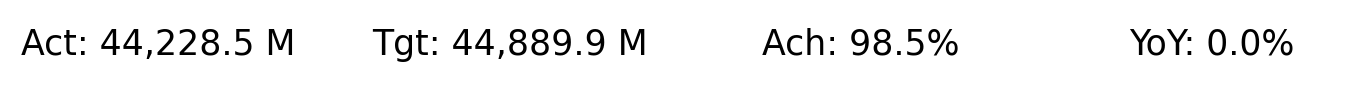

In [320]:
''' Yearly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(y_yr_act.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(y_yr_tgt.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(y_yr_achv.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"YoY: {format(y_yr_yoy.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

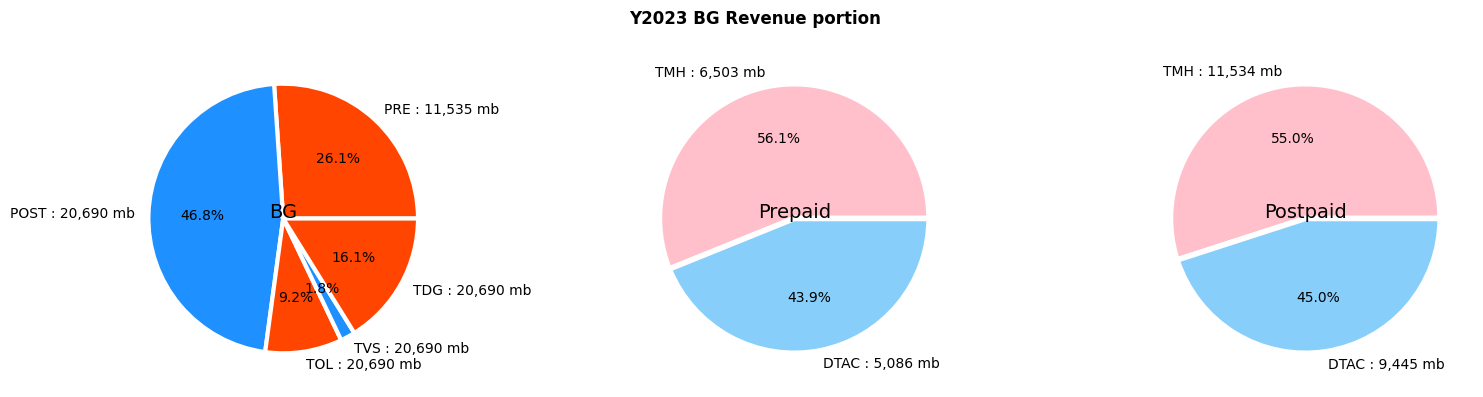

In [332]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(16, 4))
fig.suptitle(f'Y{curr_yr} BG Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([y_yr_act_pre.sum(), y_yr_act_post.sum(), y_yr_act_tol.sum(), y_yr_act_tvs.sum(), y_yr_act_tdg.sum()])
mylabels = [f"PRE : {format(y[0],',.0f')} mb", f"POST : {format(y[1],',.0f')} mb", f"TOL : {format(y[1],',.0f')} mb", f"TVS : {format(y[1],',.0f')} mb", f"TDG : {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 3, "edgecolor": "white"})#, hatch='/'
ax1.text(0, 0, 'BG', ha='center', fontsize=14)

''' ax2 '''
y = np.array([y_yr_act_pre_tmh.sum(), y_yr_act_pre_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["pink", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'Prepaid', ha='center', fontsize=14)

''' ax3 '''
y = np.array([y_yr_act_post_tmh.sum(), y_yr_act_post_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["pink", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Postpaid', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

### YR : Aggregation(lagacy)

In [81]:
''' Pivot data '''

''' Pivot Actual by KPIS '''
df_rev_act_pivot = df.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC'], columns=['METRIC_NAME'], values='ACTUAL_SNAP').reset_index()
df_rev_act_pivot.rename(columns=({'Postpaid Revenue': 'ACT_POST', 'Postpaid Revenue : DTAC': 'ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'ACT_POST_TMH',
                                  'Prepaid Revenue': 'ACT_PRE', 'Prepaid Revenue : DTAC': 'ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'ACT_PRE_TMH',
                                  'TDG Revenue (Performance View)': 'ACT_TDG', 'TOL Revenue': 'ACT_TOL', 'TVS Revenue': 'ACT_TVS'}), inplace=True)

''' Pivot Target by KPIS '''
df_rev_tgt_pivot = df.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='TARGET_SNAP').reset_index()
df_rev_tgt_pivot.rename(columns=({'Postpaid Revenue': 'TGT_POST', 'Postpaid Revenue : DTAC': 'TGT_POST_DTAC', 'Postpaid Revenue : TMH': 'TGT_POST_TMH',
                                  'Prepaid Revenue': 'TGT_PRE', 'Prepaid Revenue : DTAC': 'TGT_PRE_DTAC', 'Prepaid Revenue : TMH': 'TGT_PRE_TMH',
                                  'TDG Revenue (Performance View)': 'TGT_TDG', 'TOL Revenue': 'TGT_TOL', 'TVS Revenue': 'TGT_TVS'}), inplace=True)

''' Aggregation '''
df_rev_pivot_agg = pd.merge(df_rev_act_pivot, df_rev_tgt_pivot, on='TM_KEY_DAY')
df_rev_pivot_agg['WK_LABEL'] = df_rev_pivot_agg['TM_KEY_WK'].apply(str).str[5:].astype(int)
df_rev_pivot_agg['DAY_LABEL'] = df_rev_pivot_agg['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df_rev_pivot_agg.tail(3)

METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,...,TGT_POST_DTAC,TGT_POST_TMH,TGT_PRE,TGT_PRE_DTAC,TGT_PRE_TMH,TGT_TDG,TGT_TOL,TGT_TVS,WK_LABEL,DAY_LABEL
94,20230603,2023022,202306,20232,2023,June,NaN,97.676929,NaN,129.269069,...,99.519026,NaN,124.539946,55.777897,68.762048,NaN,NaN,NaN,22,3
95,20230604,2023022,202306,20232,2023,June,NaN,97.417088,NaN,119.263478,...,99.066770,NaN,123.392007,54.629959,68.762048,NaN,NaN,NaN,22,4
96,20230605,2023023,202306,20232,2023,June,NaN,94.137850,NaN,NaN,...,96.836864,NaN,NaN,55.473989,NaN,NaN,NaN,NaN,23,5


In [83]:
''' Aggregate by year '''
df_rev_yr = df_rev_pivot_agg.groupby('TM_KEY_YR')\
    .sum(numeric_only=True)[['ACT_POST', 'ACT_POST_DTAC', 'ACT_POST_TMH', 'ACT_PRE', 'ACT_PRE_DTAC', 'ACT_PRE_TMH', 'ACT_TDG', 'ACT_TOL', 'ACT_TVS', 
                             'TGT_POST', 'TGT_POST_DTAC', 'TGT_POST_TMH', 'TGT_PRE', 'TGT_PRE_DTAC', 'TGT_PRE_TMH', 'TGT_TDG', 'TGT_TOL', 'TGT_TVS']].reset_index()

''' % Achievement '''
df_rev_yr['%ACHV_POST'] = (df_rev_yr['ACT_POST'] / df_rev_yr['TGT_POST'])
df_rev_yr['%ACHV_POST_DTAC'] = (df_rev_yr['ACT_POST_DTAC'] / df_rev_yr['TGT_POST_DTAC'])
df_rev_yr['%ACHV_POST_TMH'] = (df_rev_yr['ACT_POST_TMH'] / df_rev_yr['TGT_POST_TMH'])
df_rev_yr['%ACHV_PRE'] = (df_rev_yr['ACT_PRE'] / df_rev_yr['TGT_PRE'])
df_rev_yr['%ACHV_PRE_DTAC'] = (df_rev_yr['ACT_PRE_DTAC'] / df_rev_yr['TGT_PRE_DTAC'])
df_rev_yr['%ACHV_PRE_TMH'] = (df_rev_yr['ACT_PRE_TMH'] / df_rev_yr['TGT_PRE_TMH'])
df_rev_yr['%ACHV_TDG'] = (df_rev_yr['ACT_TDG'] / df_rev_yr['TGT_TDG'])
df_rev_yr['%ACHV_TOL'] = (df_rev_yr['ACT_TOL'] / df_rev_yr['TGT_TOL'])
df_rev_yr['%ACHV_TVS'] = (df_rev_yr['ACT_TVS'] / df_rev_yr['TGT_TVS'])

''' Achievement Gap '''
df_rev_yr['GAP_POST'] = df_rev_yr['ACT_POST'] - df_rev_yr['TGT_POST']
df_rev_yr['GAP_POST_DTAC'] = df_rev_yr['ACT_POST_DTAC'] - df_rev_yr['TGT_POST_DTAC']
df_rev_yr['GAP_POST_TMH'] = df_rev_yr['ACT_POST_TMH'] - df_rev_yr['TGT_POST_TMH']
df_rev_yr['GAP_PRE'] = df_rev_yr['ACT_PRE'] - df_rev_yr['TGT_PRE']
df_rev_yr['GAP_PRE_DTAC'] = df_rev_yr['ACT_PRE_DTAC'] - df_rev_yr['TGT_PRE_DTAC']
df_rev_yr['GAP_PRE_TMH'] = df_rev_yr['ACT_PRE_TMH'] - df_rev_yr['TGT_PRE_TMH']
df_rev_yr['GAP_TDG'] = df_rev_yr['ACT_TDG'] - df_rev_yr['TGT_TDG']
df_rev_yr['GAP_TOL'] = df_rev_yr['ACT_TOL'] - df_rev_yr['TGT_TOL']
df_rev_yr['GAP_TVS'] = df_rev_yr['ACT_TVS'] - df_rev_yr['TGT_TVS']

''' Diff Last Year '''
df_rev_yr['DIFF_POST'] = df_rev_yr['ACT_POST'].diff()
df_rev_yr['DIFF_POST_DTAC'] = df_rev_yr['ACT_POST_DTAC'].diff()
df_rev_yr['DIFF_POST_TMH'] = df_rev_yr['ACT_POST_TMH'].diff()
df_rev_yr['DIFF_PRE'] = df_rev_yr['ACT_PRE'].diff()
df_rev_yr['DIFF_PRE_DTAC'] = df_rev_yr['ACT_PRE_DTAC'].diff()
df_rev_yr['DIFF_PRE_TMH'] = df_rev_yr['ACT_PRE_TMH'].diff()
df_rev_yr['DIFF_TDG'] = df_rev_yr['ACT_TDG'].diff()
df_rev_yr['DIFF_TOL'] = df_rev_yr['ACT_TOL'].diff()
df_rev_yr['DIFF_TVS'] = df_rev_yr['ACT_TVS'].diff()

''' Last Year Actual '''
df_rev_yr['LAST_ACT_POST'] = df_rev_yr['ACT_POST'] - df_rev_yr['DIFF_POST']
df_rev_yr['LAST_ACT_POST_DTAC'] = df_rev_yr['ACT_POST_DTAC'] - df_rev_yr['DIFF_POST_DTAC']
df_rev_yr['LAST_ACT_POST_TMH'] = df_rev_yr['ACT_POST_TMH'] - df_rev_yr['DIFF_POST_TMH']
df_rev_yr['LAST_ACT_PRE'] = df_rev_yr['ACT_PRE'] - df_rev_yr['DIFF_PRE']
df_rev_yr['LAST_ACT_PRE_DTAC'] = df_rev_yr['ACT_PRE_DTAC'] - df_rev_yr['DIFF_PRE_DTAC']
df_rev_yr['LAST_ACT_PRE_TMH'] = df_rev_yr['ACT_PRE_TMH'] - df_rev_yr['DIFF_PRE_TMH']
df_rev_yr['LAST_ACT_TDG'] = df_rev_yr['ACT_TDG'] - df_rev_yr['DIFF_TDG']
df_rev_yr['LAST_ACT_TOL'] = df_rev_yr['ACT_TOL'] - df_rev_yr['DIFF_TOL']
df_rev_yr['LAST_ACT_TVS'] = df_rev_yr['ACT_TVS'] - df_rev_yr['DIFF_TVS']

''' % Year on year '''
df_rev_yr['%YOY_POST'] = (df_rev_yr['ACT_POST'] / df_rev_yr['LAST_ACT_POST']) - 1
df_rev_yr['%YOY_POST_DTAC'] = (df_rev_yr['ACT_POST_DTAC'] / df_rev_yr['LAST_ACT_POST_DTAC']) - 1
df_rev_yr['%YOY_POST_TMH'] = (df_rev_yr['ACT_POST_TMH'] / df_rev_yr['LAST_ACT_POST_TMH']) - 1
df_rev_yr['%YOY_PRE'] = (df_rev_yr['ACT_PRE'] / df_rev_yr['LAST_ACT_PRE']) - 1
df_rev_yr['%YOY_PRE_DTAC'] = (df_rev_yr['ACT_PRE_DTAC'] / df_rev_yr['LAST_ACT_PRE_DTAC']) - 1
df_rev_yr['%YOY_PRE_TMH'] = (df_rev_yr['ACT_PRE_TMH'] / df_rev_yr['LAST_ACT_PRE_TMH']) - 1
df_rev_yr['%YOY_TDG'] = (df_rev_yr['ACT_TDG'] / df_rev_yr['LAST_ACT_TDG']) - 1
df_rev_yr['%YOY_TOL'] = (df_rev_yr['ACT_TOL'] / df_rev_yr['LAST_ACT_TOL']) - 1
df_rev_yr['%YOY_TVS'] = (df_rev_yr['ACT_TVS'] / df_rev_yr['LAST_ACT_TVS']) - 1

df_rev_yr
# df_rev_yr.to_excel("temp.xlsx")

METRIC_NAME,TM_KEY_YR,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,ACT_TVS,...,LAST_ACT_TVS,%YOY_POST,%YOY_POST_DTAC,%YOY_POST_TMH,%YOY_PRE,%YOY_PRE_DTAC,%YOY_PRE_TMH,%YOY_TDG,%YOY_TOL,%YOY_TVS
0,2023,20690.35239,9445.087155,11534.497102,11535.208678,5085.924521,6503.052722,7141.721325,4079.219788,782.042385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ** Monthly

### MTH : Aggregation

In [ ]:
df_tmp_mth = df.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()

''' Aggregation '''
df_tmp_mth['%ACHV'] = (df_tmp_mth['ACTUAL_SNAP'] / df_tmp_mth['TARGET_SNAP'])
df_tmp_mth['GAP'] = df_tmp_mth['ACTUAL_SNAP'] - df_tmp_mth['TARGET_SNAP']
df_tmp_mth['LAST_ACT'] = df_tmp_mth.groupby('METRIC_CD')['ACTUAL_SNAP'].shift()
df_tmp_mth['DIFF'] = df_tmp_mth['ACTUAL_SNAP'] - df_tmp_mth['LAST_ACT']
df_tmp_mth['%YOY'] = (df_tmp_mth['ACTUAL_SNAP'] / df_tmp_mth['LAST_ACT']) - 1

# df_tmp_mth.to_excel('df_tmp_mth.xlsx')
df_tmp_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,ACTUAL_SNAP,TARGET_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
31,TB4R000100,TVS Revenue,202306,0.000000,0.0,NaN,0.000000,236.218241,-236.218241,-1.00000
32,TNSC00142,TDG Revenue (Performance View),202303,2294.948805,2088.0,1.099113,206.948805,NaN,NaN,NaN
33,TNSC00142,TDG Revenue (Performance View),202304,2060.772520,2140.0,0.962978,-79.227480,2294.948805,-234.176284,-0.10204
34,TNSC00142,TDG Revenue (Performance View),202305,2786.000000,2515.0,1.107753,271.000000,2060.772520,725.227480,0.35192
35,TNSC00142,TDG Revenue (Performance View),202306,0.000000,0.0,NaN,0.000000,2786.000000,-2786.000000,-1.00000
